## Finite Difference swaption

In [1]:
import os
import sys

current_dir = os.getcwd()
qg_dir = os.path.join(current_dir, "..")

sys.path.append(qg_dir)

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['text.usetex'] = True
from quassigaussian.finitedifference.mesher.linear_mesher import extract_x0_result

In [3]:
from quassigaussian.finitedifference.adi.run_adi import AdiRunner
from quassigaussian.parameters.volatility.local_volatility import LinearLocalVolatility
from quassigaussian.products.instruments import Bond
from quassigaussian.products.instruments import Swap, Swaption
from quassigaussian.products.pricer import SwapPricer, SwaptionPricer, find_implied_black_vola

from quassigaussian.products.pricer import BondPricer
from quassigaussian.finitedifference.mesher.grid_boundaries import calculate_x_boundaries2, calculate_u_boundaries, calculate_x_boundaries3
from quassigaussian.finitedifference.mesher.linear_mesher import Mesher2d
import pandas as pd
import os
from qgtests.utis import get_mock_yield_curve_const

In [4]:
# Constructing local volatility and curve object

swaption_expiry=5
swap_maturity = 10

curve_rate = 0.06

kappa = 0.03
theta = 1/2
initial_curve = get_mock_yield_curve_const(rate=curve_rate)

loca_vola = LinearLocalVolatility.from_const(swap_maturity, 0.4, 0.06, 0.2)
t_max = swap_maturity
t_min = 0

In [5]:
swap = Swap(swaption_expiry, swap_maturity, frequency=0.5)
initial_curve = get_mock_yield_curve_const(rate=0.04)

swap_pricer = SwapPricer(initial_curve, kappa)

atm_swap_price = swap_pricer.price(swap, 0, 0, 0)


In [6]:
# Constructing mesh

t_grid_size = 100
x_grid_size = 150
u_grid_size = 20


x_min, x_max = calculate_x_boundaries3(t_max, kappa, loca_vola, alpha=3)
u_min, u_max = calculate_u_boundaries(t_max, kappa, loca_vola, alpha=4)

mesher = Mesher2d()
mesher.create_mesher_2d(t_min, t_max, t_grid_size, x_min, x_max, x_grid_size, u_min, u_max,
                        u_grid_size)


In [7]:
# Coupon grid that we are going to price

coupon_grid = [0, +0.005, -0.005, +0.01, -0.01, 0.015, -0.015]

strike_grid = [atm_swap_price+coupon for coupon in coupon_grid]
swaption_pricer = SwaptionPricer(swap_pricer)

adi_runner = AdiRunner(theta, kappa, initial_curve, loca_vola, mesher)


In [8]:
# Run ADI pricer

output_df_ls = []
for strike in strike_grid:
    swaption = Swaption(swaption_expiry, strike, swap)
    swaption_t0 = pd.DataFrame(adi_runner.run_adi(swaption, swaption_pricer))
    swaption_t0_x0_y0 = extract_x0_result(swaption_t0.values, mesher.xgrid, mesher.ugrid)
    implied_black_vola = find_implied_black_vola(swaption_t0_x0_y0, swaption, swap_pricer, swap_pricer.bond_pricer)

    meta_data = {"expiry": swaption_expiry, "maturity": swap_maturity, "strike": strike,
                 "atm strike": atm_swap_price, "moneyness": strike - atm_swap_price,
                 "swaption_value": swaption_t0_x0_y0, "implied_black_vola": implied_black_vola}

    meta_data_df = pd.DataFrame(meta_data, index=[0])
    output_df_ls.append(meta_data_df)

9.8989898989899
9.797979797979798
9.696969696969697
9.595959595959595
9.494949494949495
9.393939393939394
9.292929292929292
9.191919191919192
9.09090909090909
8.98989898989899
8.88888888888889
8.787878787878787
8.686868686868687
8.585858585858587
8.484848484848484
8.383838383838384
8.282828282828282
8.181818181818182
8.080808080808081
7.979797979797979
7.878787878787879
7.777777777777778
7.6767676767676765
7.575757575757575
7.474747474747475
7.373737373737374
7.2727272727272725
7.171717171717171
7.070707070707071
6.96969696969697
6.8686868686868685
6.767676767676767
6.666666666666667
6.565656565656566
6.4646464646464645
6.363636363636363
6.262626262626262
6.161616161616162
6.0606060606060606
5.959595959595959
5.858585858585858
5.757575757575758
5.656565656565657
5.555555555555555
5.454545454545454
5.353535353535354
5.252525252525253
5.151515151515151
5.05050505050505
4.94949494949495
4.848484848484849
4.747474747474747
4.646464646464646
4.545454545454545
4.444444444444445
4.34343434343

4.141414141414141
4.040404040404041
3.9393939393939394
3.8383838383838382
3.7373737373737375
3.6363636363636362
3.5353535353535355
3.4343434343434343
3.3333333333333335
3.2323232323232323
3.131313131313131
3.0303030303030303
2.929292929292929
2.8282828282828283
2.727272727272727
2.6262626262626263
2.525252525252525
2.4242424242424243
2.323232323232323
2.2222222222222223
2.121212121212121
2.0202020202020203
1.9191919191919191
1.8181818181818181
1.7171717171717171
1.6161616161616161
1.5151515151515151
1.4141414141414141
1.3131313131313131
1.2121212121212122
1.1111111111111112
1.0101010101010102
0.9090909090909091
0.8080808080808081
0.7070707070707071
0.6060606060606061
0.5050505050505051
0.40404040404040403
0.30303030303030304
0.20202020202020202
0.10101010101010101
0.0
9.8989898989899
9.797979797979798
9.696969696969697
9.595959595959595
9.494949494949495
9.393939393939394
9.292929292929292
9.191919191919192
9.09090909090909
8.98989898989899
8.88888888888889
8.787878787878787
8.68686868

In [9]:
fd_swaption = pd.concat(output_df_ls)

In [10]:
fd_swaption = fd_swaption.sort_values("moneyness")

### Plotting

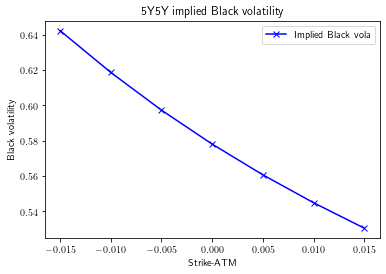

In [11]:
plt.plot(fd_swaption["moneyness"], fd_swaption["implied_black_vola"], "b-x", label="Implied Black vola")
plt.title("5Y5Y implied Black volatility")
plt.xlabel("Strike-ATM")
plt.ylabel("Black volatility")
plt.legend()